# Credit Card Fraud Detection
<ul>
    <li>I - Introduction</li>
    <li>II - Exploring the datas</li>
</ul>

## I - Introduction

### Context
<p style="text-align:justify;">It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.</p>

### Content
<p style="text-align:justify;">The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.</p>

<p style="text-align:justify;">It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.</p>

### Inspiration
Identify fraudulent credit card transactions.

<p style="text-align:justify;">Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.</p>

### Acknowledgements
<p style="text-align:justify;">The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on http://mlg.ulb.ac.be/BruFence and http://mlg.ulb.ac.be/ARTML</p>

<p style="text-align:justify;">Please cite: Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015</p>

## II - Exploring the datas
Let's take a look at the datas to make decisions on what type model we should use.
### 1. Importing the datas

In [222]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import random
import scipy.stats as st
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import math

In [223]:
datas = pd.read_csv("../../too_big_datas/credit_card/creditcard.csv")

In [224]:
display(datas.head())
print("The shape of the datas is {}".format(datas.shape))

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The shape of the datas is (284807, 31)


### 2. Quick data overview
<ul>
    <li><b>Time:</b> Number of seconds elapsed between the first transaction and this transaction.</li>
    <li><p style="text-align:justify;"><b>V1-28:</b> Input variables after PCA transformation. (PCA = Mathematic transformation that cannot be reversed to orthogonalize datas. Its role here is to provide security by respecting the privacy of the cardholders. But no information is lost in this transformation.)</p></li>
    <li><b>Amount:</b> The amount of the transaction.</li>
    <li><b>Class:</b> It is the label of the datas. 1 = case of fraud, 0 = otherwise.</li>
</ul>
<p style="text-align:justify;">This dataset contains transactions that occured in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.</p>

### 3. How to choose a type of algorithm?

In [225]:
counts = pd.value_counts(datas["Class"], ascending=True)
print("The number of Fraudulent transactions is: {}".format(counts[1]))
print("The number of Normal transactions is: {}".format(counts[0]))
print("The ratio is: {:.3f}%".format(counts[1]/counts[0]*100))

The number of Fraudulent transactions is: 492
The number of Normal transactions is: 284315
The ratio is: 0.173%


<p style="text-align:justify;">In this case we have a lot of negative examples (normal transaction) compare to the number of positive examples (fraudulent transaction). So what should we choose? First question: Unsupervised or Supervised learning algorithm?</p>

<p style="text-align:justify;">In this case I would tend to use an unsupervised learning algorithm. Here is why: When you have a comparable number of positive and negative examples the algorithm can learn the characteristics of the anomalies easily. Thus we should use a classic classification algorithm => Supervised learning. But when we have a lot more informations of what a normal example looks like, we should learn what a positive example is instead. After the algorithm finish learning it can detect when an example is "not normal".</p>

This technics uses Gaussian Distribution.
### 4. Crash course on Gaussian Distribution
<p style="text-align:justify;">The idea behind this algorithm is that if we choose the measured features widely we can see it in a graph when there is an anomaly. For example if you were building to verify if an engine does not have any anomaly, you might mesure heat and vibrations while it is testing. Then if you plot this datas, an abnormal engine will have its point far from the other engines which are normal.</p>


<img style="float:left;" height="500" width="500" src="anomaly_detection.png"/>
<img style="float:left;" height="450" width="450" src="anomaly_detection2.png"/>

<p style="float:left;text-align:justify;">We determine the gaussian model that best fits the datas for the negative examples (image on the right). The center of this graph is where the gaussian is higher. This is where the chances for an example are higher. The farer we get from the center the less probable it is for an example to be normal.</p>

### 5. Anomaly detection using normal distribution

To perform anomaly detection using gaussian distribution there are three steps to follow:

<b>First step</b>

<p style="text-align:justify;">We need to choose the different features $x_{i}$. This features needs to be helpfull in determining weither the example is an anomaly or not.</p>

<b>Second step</b>

<p style="text-align:justify;">We need to fit the different parameters of the gaussians. If we have m examples we need to fit $\mu_{1}$, ..., $\mu_{m}$, $\sigma_{1}^{2}$, ..., $\sigma_{m}^{2}$. We can do so using these two formulas: </p>

$\mu_{j}=\frac{1}{m} \sum_{i=1}^{m}x_{j}^{(i)}$

$\sigma_{j}^{2}=\frac{1}{m} \sum_{i=1}^{m}(x_{j}^{(i)}-\mu_{j})^{2}$


<b>Third step</b>

<p style="text-align:justify;">Now that we have trained our algorithm, we can make predictions on a new example x, using the following formula:</p>

$p(x)=\prod_{j=1}^{n}p(x_{j};\mu_{j},\sigma_{j}^{2})=\prod_{j=1}^{n}\frac{1}{\sqrt{2\pi}\sigma_{j}}exp\left(-\frac{\left (x_{j}-\mu_{j}\right)^{2}}{2\sigma_{j}^{2}}\right )$

There is an anomaly when $p(x) < \epsilon$

<p style="text-align:justify;">The formula with the exponential is just the formula for the gaussian distribution. We obtain this multiplication because we suppose that all the datas are independant. This is the case for the project we are studying but it is generally not a big deal.</p>

### 6. Splitting the dataset
<p style="text-align:justify;">For this algorithm, we need to separate positive examples from negative examples. But we also need to determine the threshold: $\epsilon$. To do so, we need to make a Cross-Validation dataset. So we need three datasets:<ul>
    <li>Training dataset: 60% of good dataset</li>
    <li>Cross-Validation dataset: 20% of good dataset / 50% of anomalous dataset</li>
    <li>Test dataset:  20% of good dataset / 50% of anomalous dataset</li>
</ul>
</p>

In [226]:
scaler = MinMaxScaler()
datas[datas.columns.drop("Class")] = scaler.fit_transform(datas[datas.columns.drop("Class")])

#We split the normal/fraud datasets
fraud_datas = datas[datas.Class==1]
normal_datas = datas[datas.Class==0]

print("Fraud datas: {}".format(fraud_datas.shape))
print("Normal datas: {}".format(normal_datas.shape))

train_normal, validate_normal, test_normal = np.split(normal_datas, [int(len(normal_datas)*.6), int(len(normal_datas)*.8)])
validate_fraud, test_fraud = np.split(fraud_datas, 2)

train_datas = train_normal
valid_datas = pd.concat([validate_normal, validate_fraud])
test_datas = pd.concat([test_normal, test_fraud])

print()
print("datas: \tshape: \t\tnbr_fraud \tnbr_normal")
print("Train \t{} \t{} \t\t{}".format(train_datas.shape, len(train_datas[train_datas.Class==1]), len(train_datas[train_datas.Class==0])))
print("CV \t{} \t{} \t\t{}".format(valid_datas.shape, len(valid_datas[valid_datas.Class==1]), len(valid_datas[valid_datas.Class==0])))
print("Test \t{} \t{} \t\t{}".format(test_datas.shape, len(test_datas[test_datas.Class==1]), len(test_datas[test_datas.Class==0])))

Fraud datas: (492, 31)
Normal datas: (284315, 31)

datas: 	shape: 		nbr_fraud 	nbr_normal
Train 	(170589, 31) 	0 		170589
CV 	(57109, 31) 	246 		56863
Test 	(57109, 31) 	246 		56863


### 7. Fitting the parameters

#### Using numpy

In [227]:
y_train = train_datas.Class
X_train = train_datas.drop(["Class"], axis=1)

mu = np.mean(X_train.values, axis=0)
sigma = np.var(X_train.values, axis=0)

#### Using TensorFlow

### 8. Visualizing the datas

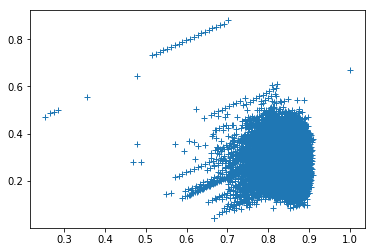

0.8462596552810553
0.0004899253617417374
0.29622392786231627
0.003700585279931726


In [229]:
plt.plot(train_datas["V3"], train_datas["V11"], "+")

x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
xv, yv = np.meshgrid(x, y)

plt.show()
print(mu[3])
print(sigma[3])
print(mu[11])
print(sigma[11])

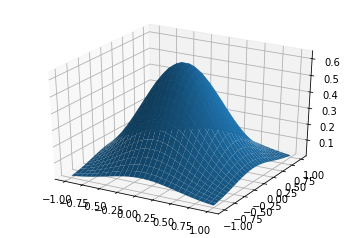

In [230]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
from scipy.stats import multivariate_normal

x, y = np.mgrid[-1.0:1.0:30j, -1.0:1.0:30j]

# Need an (N, 2) array of (x, y) pairs.
xy = np.column_stack([x.flat, y.flat])

mu = np.array([0.0, 0.0])

sigma = np.array([.5, .5])
covariance = np.diag(sigma**2)

z = multivariate_normal.pdf(xy, mean=mu, cov=covariance)

# Reshape back to a (30, 30) grid.
z = z.reshape(x.shape)





fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')



ax.plot_surface(x,y,z)
#ax.plot_wireframe(x,y,z)

plt.show()

### 8. Prediction

In [231]:
y_valid = valid_datas.Class
X_valid = valid_datas.drop(["Class"], axis=1)
display(X_valid.values.shape)

predict = np.ones((X_valid.values.shape[0], 1))

for example in X_valid.values:
    p_x = 1
    for j in range(len(mu)):
        if not j == 0 and not j == 29:
            p_x *= 1 / (math.sqrt(2 * math.pi) * sigma[j]) * math.exp(-(example[j] - mu[j]) / (2 * sigma[j]))
    
example = X_valid.values[100]
p_x = 1
for j in range(len(mu)):
    if not j == 0 and not j == 29:
        print(1 / (math.sqrt(2 * math.pi) * sigma[j]) * math.exp(-(example[j] - mu[j]) / (2 * sigma[j])))
        
display(predict[100])

(57109, 30)

0.30591335533391667


array([1.])

## III - Examining the features

In [232]:
v_features = datas.ix[:,1:29].columns

C:\Users\roland\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


For this algorithm to work well, we need to choose/pre-process the features as follow:
<ul>
    <li>It needs to have a (semi) gaussian distribution</li>
    <li>p(x) needs to be large for normal and small for fraud.</li>
    <li>It is preferable that the feature has very large or very small values for anomalies.</li>
</ul>

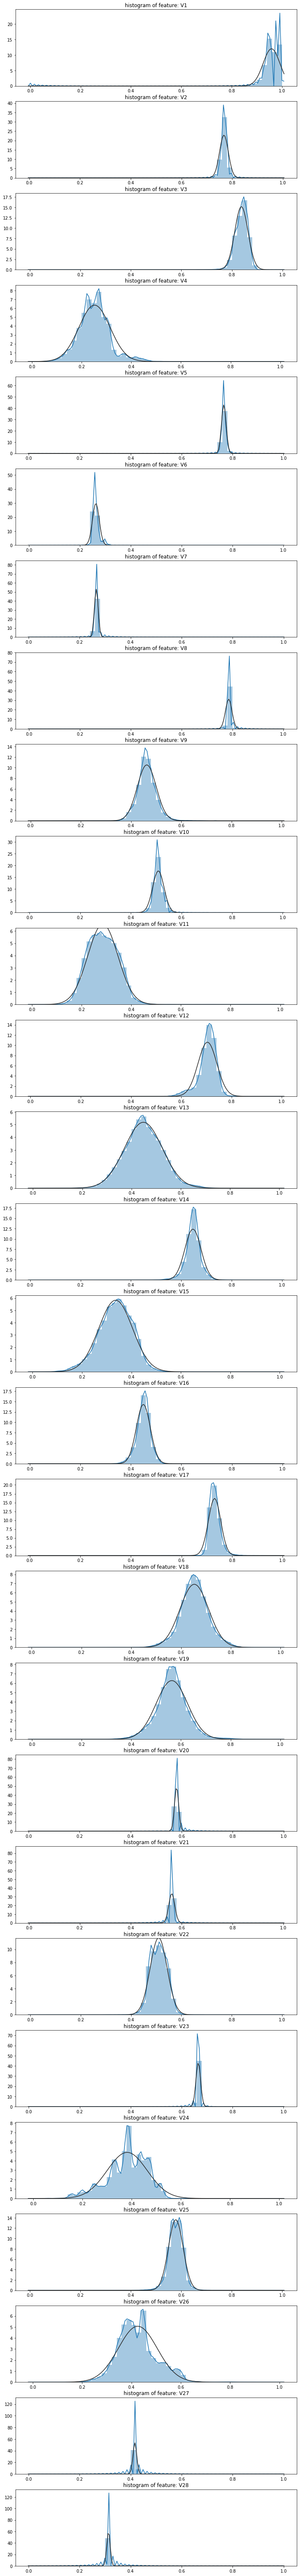

In [233]:
plt.figure(figsize=(12,28*4))
gs = gridspec.GridSpec(28, 1)
for i, cn in enumerate(datas[v_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(datas[cn], fit=st.norm, bins=50)
    ax.set_xlabel('')
    ax.set_title("histogram of feature: " +str(cn))
plt.show()

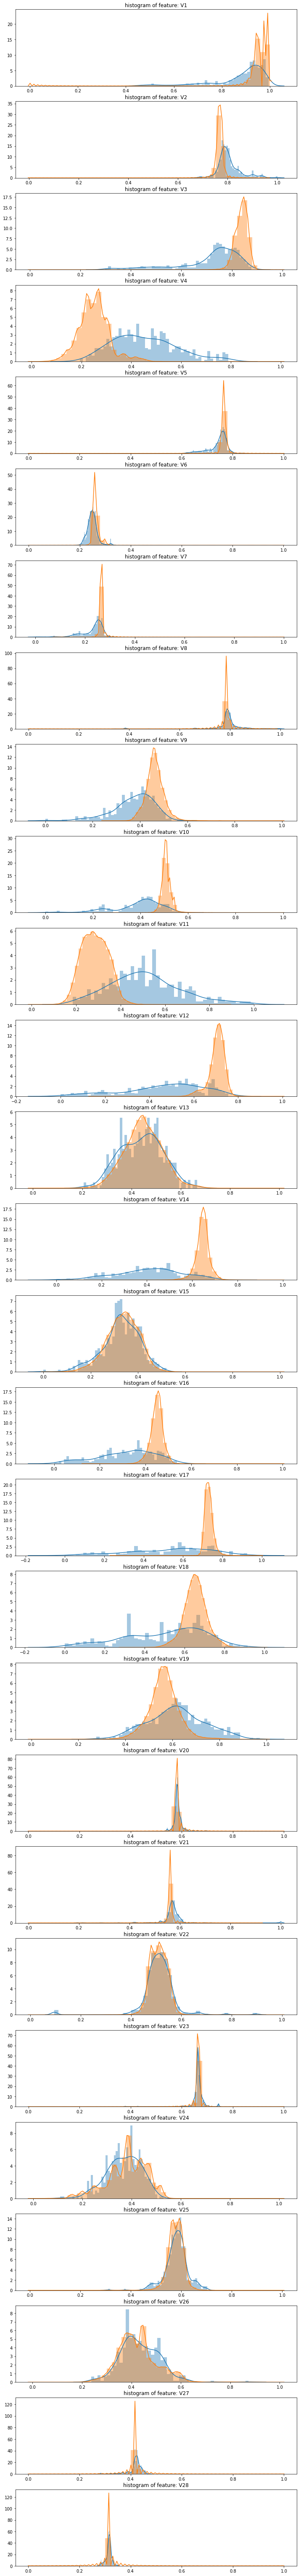

In [234]:
plt.figure(figsize=(12,28*4))
gs = gridspec.GridSpec(28, 1)
for i, cn in enumerate(datas[v_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(datas[cn][datas.Class == 1], bins=50)
    sns.distplot(datas[cn][datas.Class == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()

In [235]:
indexes = datas.columns[1:3]
print(indexes)

Index(['V1', 'V2'], dtype='object')


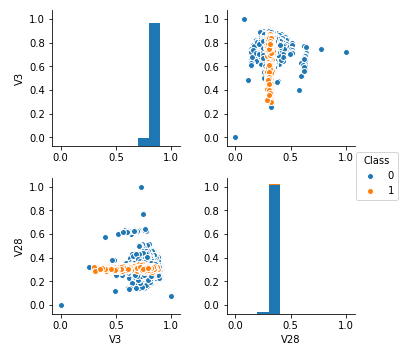

In [236]:
sns.pairplot(datas, vars=["V3", "V28"] , hue="Class")
plt.show()